# Communication Towers Problem



In this problem, there will be a space that towers will cover randomly one by one. As shown in the pdf on the class website, the problem is that the coverage, represented by rectangles, cannot overlap each other, and if a rectangle is initially overlapping another, it is trimmed so that it is a rectangle which covers the maximum area.

In my implementation of the solution to this problem, I broke it down in this fashion.

1. Create a generator function which outputs uniformally distributed rectangles.
2. Create a 2-D array that stores all the existing coverage on it.
3. Create a function that trims the rectangle so that it follows the rules and fits on the 2-D array specified above.
4. Plot the 2-D array in step 2 everytime it is updated for visualization.
5. Have a variation where we can input an integer n which specifies the number of communication towers to be mapped.

# Modules and Constants

I wanted to use numpy for easier matrix manipulation, making it easier to tackle this problem with matrices. I also imported matplotllib.pyplot for visualization and the time module so we can see the plot if it moves too fast. I made the window size a constant.

In [4]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

WINDOW_SIZE = 10
#10 square units but zero-indexed so index goes up to nine

# Rectangle Generator

Because the rectangles have to generated with a uniform distribution, I used numpy to help with this.

In [5]:
#create a generator that creates a rectangle every time we call it
def create_rectangle():
    '''
    A generator function that uses numpy to randomly generate a point, width, and height with uniform distribution
    :return: tuple of rectangle coordinates
    '''
    while True:
        bottom_left_x = np.random.randint(0,WINDOW_SIZE) #initialize the x and y coordinates anywhere 0-9
        bottom_left_y = np.random.randint(0, WINDOW_SIZE)
        width = np.random.randint(1,WINDOW_SIZE-bottom_left_x+1) #make the width a random integer from coordinate to max value
        height = np.random.randint(1,WINDOW_SIZE-bottom_left_y+1)

        rect_coord = (bottom_left_x, bottom_left_y, width, height)

        yield rect_coord

# Main Function

In the main function, I wanted to:
1. Initialize store_area, a 2-D array that holds all the rectangles and will be plotted.
2. Get the random rectangle coordinates from the generator and make a binary 2-D matrix out of it that is size(WINDOW_SIZE,WINDOW_SIZE)
3. Trim the rectangle so that it doesn't overlap with any other rectangles in store_area. We don't know how it will turn out since the trimming depends on the randomly placed rectangles in store_area, so I will refer to this as a polygon.
4. Pass the polygon to a function (to be defined later) that returns a binary 2-D array of size (WINDOW_SIZE,WINDOW_SIZE) that extracts the largest rectangle possible from the input polygon. I call this function max_area_rectangle.
5. Add the rectangle we made in step 4 to store_area and then plot it. I use imshow() from the matplotlib module because it made sense to plot the rectangles using pixels.
    - If the returned rectangle was all zero, then I wouldn't plot or update store_area
    
Here, I kept a counter that incremented whenever store_area was updated to see how many communication towers it took to cover the whole area.

To 

In [11]:
def main(n = WINDOW_SIZE*WINDOW_SIZE+1):

    assert isinstance(n,int), 'Input must be an integer'
    assert n>0, 'Input must be greater than zero'

    generate_rectangle = create_rectangle() #call the generator to get random rectangle coordinates
    animation_matrix = []
    store_area = np.zeros((WINDOW_SIZE, WINDOW_SIZE)) #initialize the global 2-D numpy array that holds all of the communication coverage

    counter = 1 #initialize counter that keeeps track of how many communication towers are plotted
    
    fig1 = plt.figure()  # initialize figure to visualize the coverage
    #ax1 = fig1.add_subplot(111, aspect='equal')
    
    while not store_area.all() and counter <= n: #while loop ends when there is no more area to cover
        rect_coord = next(generate_rectangle) #call the generator to get random coordinates

        #create the rectangle in the matrix space
        x,y,width,height = rect_coord
        rect_area = np.zeros((WINDOW_SIZE,WINDOW_SIZE))
        rect_area[x:x+width,y:y+height] = 1

        rect_area[store_area > 0] = 0 #trim the rectangle so there is no overlap

        max_rect = max_area_rectangle(rect_area) #get the largest area rectangle out of rect_area

        #if there is anything added to store_area increment the counter and update the graph
        if max_rect.any():

            store_area[max_rect > 0] = counter  # put rect_area onto store_area to graph
            print store_area
            image = plt.imshow(store_area,cmap = 'tab20', animated = True)
            animation_matrix.append([image])
            

            counter += 1


        #time.sleep(0.1) #delay for graph update

    if counter == 2:
        print 'There is 1 communication tower covering {}% of the area.'.format(100. * np.count_nonzero(store_area)/(WINDOW_SIZE*WINDOW_SIZE))
    else:
        print 'There are {} communication towers covering {}% of the area.'.format(counter-1, 100. * np.count_nonzero(store_area)/(WINDOW_SIZE*WINDOW_SIZE))

    
    print len(animation_matrix)
    print len(animation_matrix[0])
    
    ani = animation.ArtistAnimation(fig1, animation_matrix, interval = 500)
    
    plt.show()
    return counter - 1


# max_area_rectangle function

This is probably the most complex part of the entire communication towers problem. The function has to detect from a binary 2-D matrix the largest rectangle of 1's. 

I used a bar graph approach to the problem. For each row of the input polygon 2-D matrix, I calculate a bar graph of the number of sequential ones above the row in the column. From here I can calculate the max area that comes out of the bar graph.

For example, given a 2-D array, I create a bar graph of how many sequential ones are in each column.
To help visualize how to find the max area in a bar graph, say we have a row where the numbers are:
                                        [1 0 0 3 5 3 5 4 0 2]

The corresponding bar graph should look like this:![title](bar.png)

Where the red box outlines the rectangle with the largest area. To get the width and height of the red box, I loop through the row and check if the immediate columns to the right have more or equal number of ones to the column I currently am in and increment the width everytime I go to the next column. If the number of ones is less, than I break and calculate the area immediately by multiplying width by height. I do this for every column and keep track of the maximum area. When the maximum area updates, I keep track of the indices where the rectangle is.

Of course, I do this for each row because I need to look at the sequential 1's, not how many 1's there are in each column. 

When I get the width, height, and indices of the largest rectangle, I can easily map it onto a 2-D binary matrix and return it.



In [12]:
def max_area_rectangle(rect_area):
    '''
    Takes in a 2-D numpy array of a polygon and cuts it so it becomes a rectangle of the maximum area
    I take a histogram of the number of ones in each column. From there I can
    :param rect_area: 2-D array with the polygon indicated by ones
    :return: 2-D array that has a rectangle of maximum area
    '''
    max_rect = np.array(rect_area)
    #create a histogram of how many ones in each column
    area = -1
    max_width = None
    max_height = None
    index_x = None
    index_y = None

    #create an accumulating histogram top down of the input rect_area
    for a in range(0,len(max_rect)): #loop through each row of the input rect_area
        if a != 0:#we do not want to start the histogram at row 0
            for b in range(len(max_rect[0])): #loop through each column in the row a
                if max_rect[a][b] == 1: #if there is a 1 add the value above in the column
                    max_rect[a][b] += max_rect[a-1][b]


        #for each accumulating histogram row we want to calculate the area
        hist = max_rect[a]
        for i in range(len(hist)):
            width = 1
            #add to the width for every value that is greater than or equal to the right of the value hist[i]
            for g in range(i+1,len(hist)): #go down the histogram to the right
                if hist[g] >= hist[i]:
                    width += 1

                #break if there is a value less than hist[i] somewhere to the right
                else:
                    break

            #get the area by multiplying width and the height of and check if its greater than the current placeholder
            if width*hist[i]>area:
                area = hist[i]*width

                #update the values that acheived max area to put on graph
                max_height =int(hist[i])
                max_width = width
                index_y = a
                index_x = i
    #graph the largest area rectangle and return it
    max_rect = np.zeros_like(rect_area)
    max_rect[index_y-max_height+1:index_y+1,index_x:index_x+max_width] = 1

    return max_rect

# Execute

I made the function main() to have an input specifying how many communication towers to be placed. If there is no argument, then it keeps on running till the whole area is filled up.

<IPython.core.display.Javascript object>


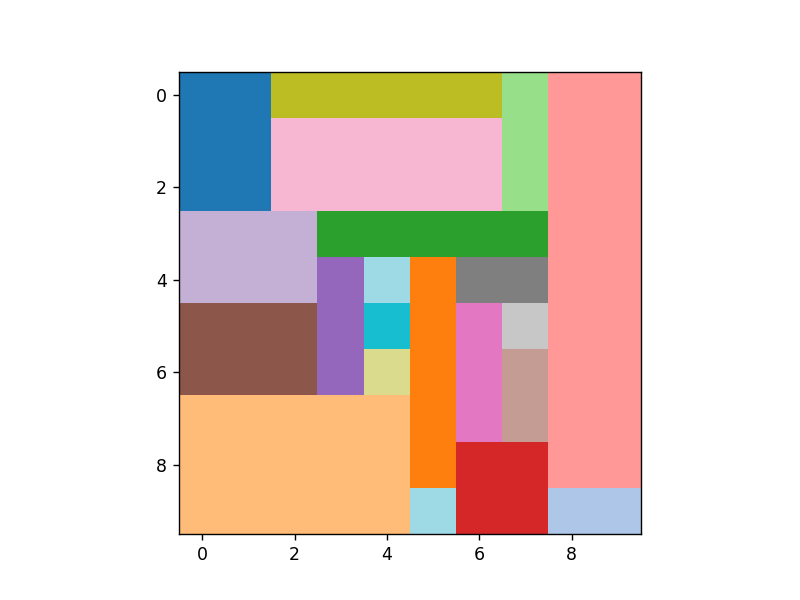

[[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  2.]]
[[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.

21

In [13]:
main()

#  Finding average number of communcation towers to cover the whole area

I am using a 10x10 area. This will run the code 50 times and then take the average number of communication towers to cover the whole area.

<IPython.core.display.Javascript object>


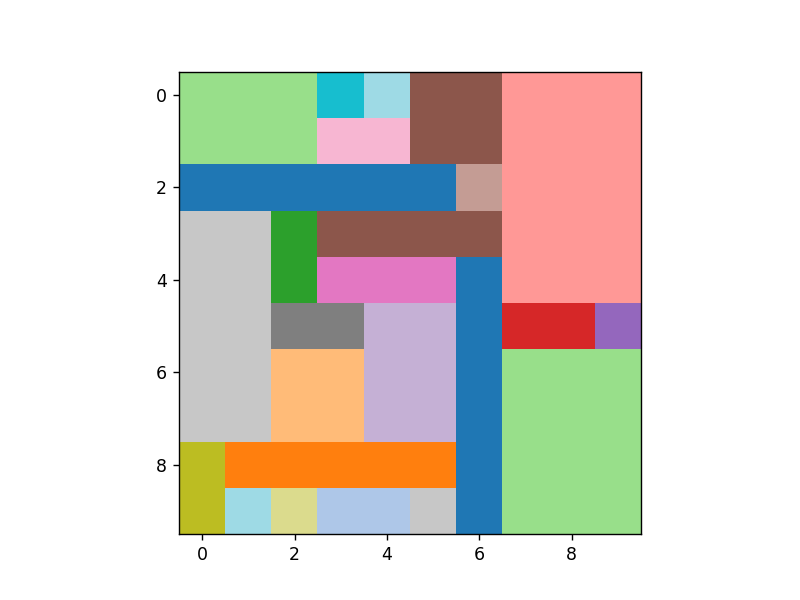

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


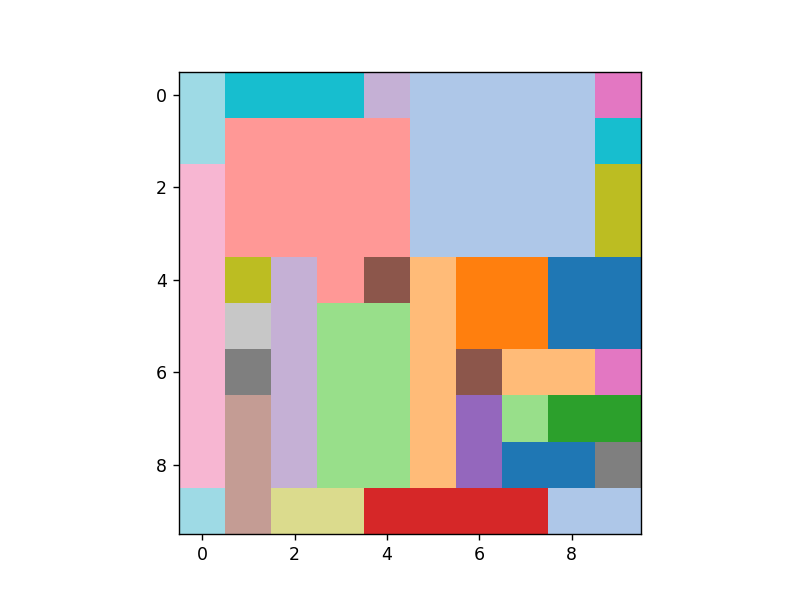

There are 32 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


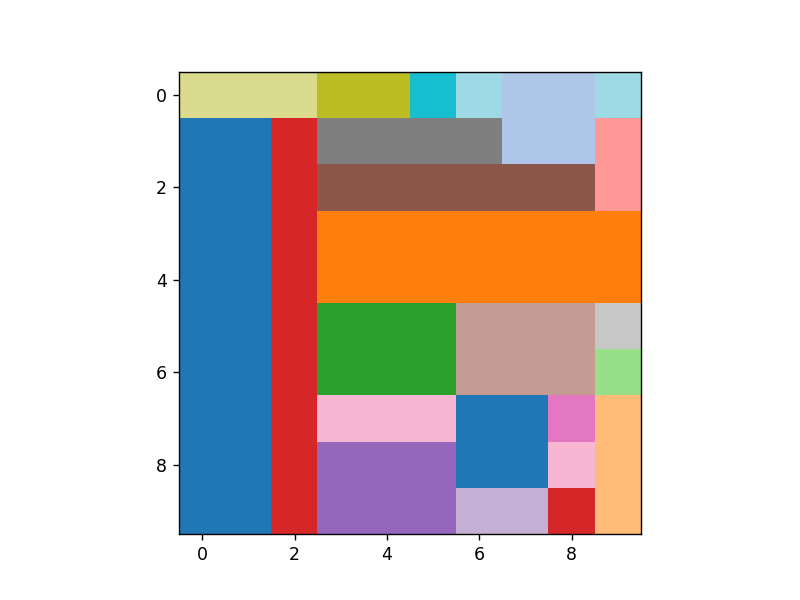

There are 24 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


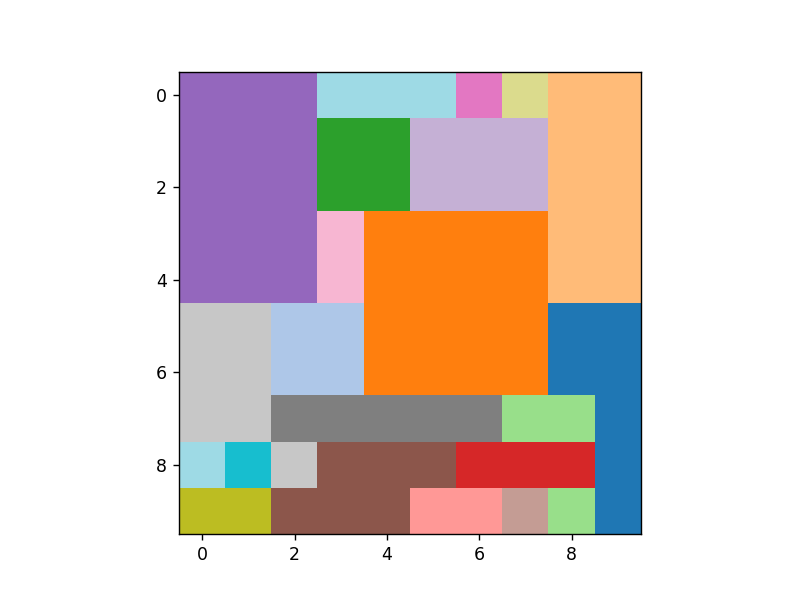

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


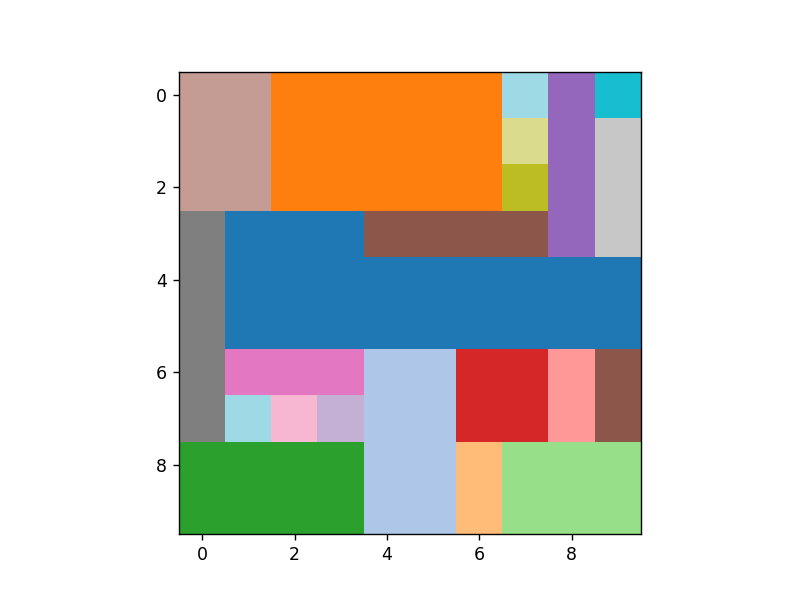

There are 23 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


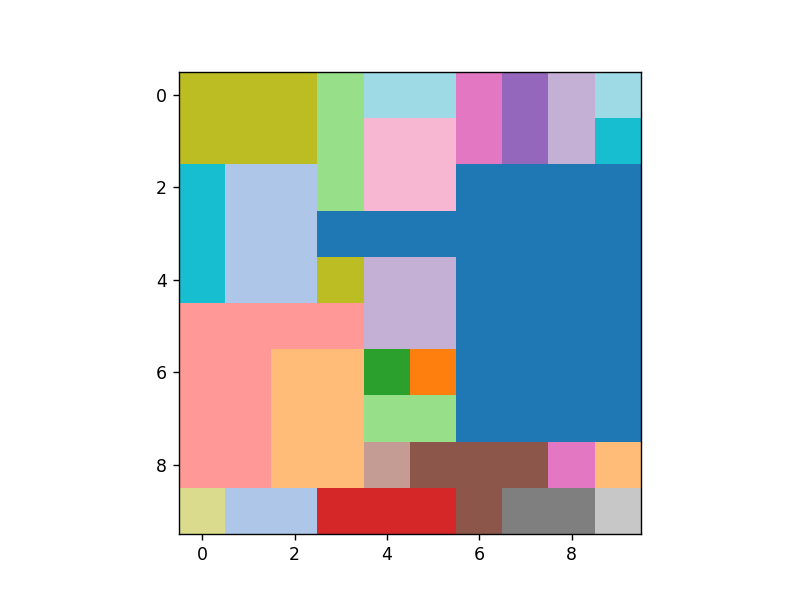

There are 32 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


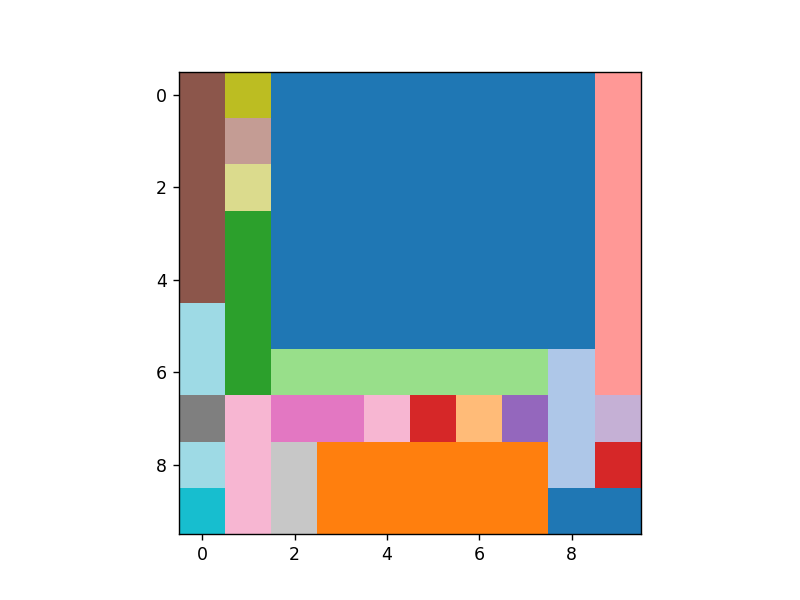

There are 24 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


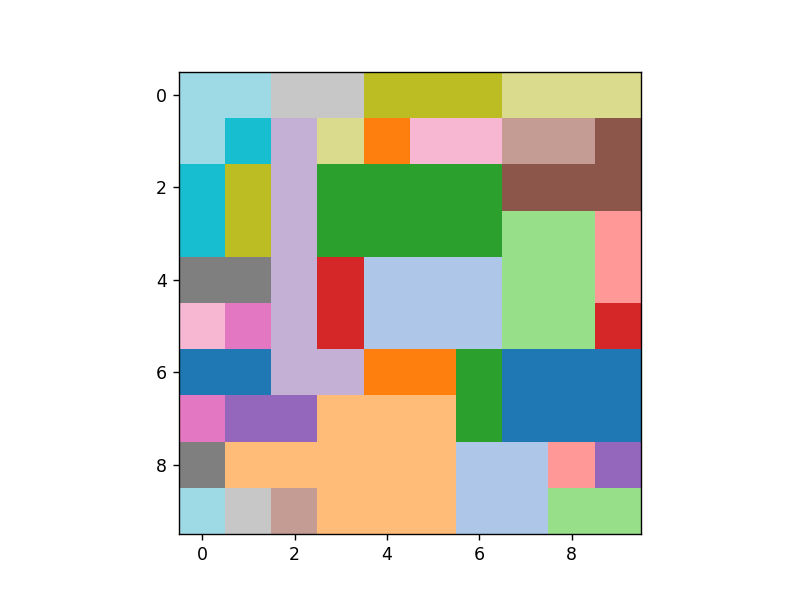

There are 41 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


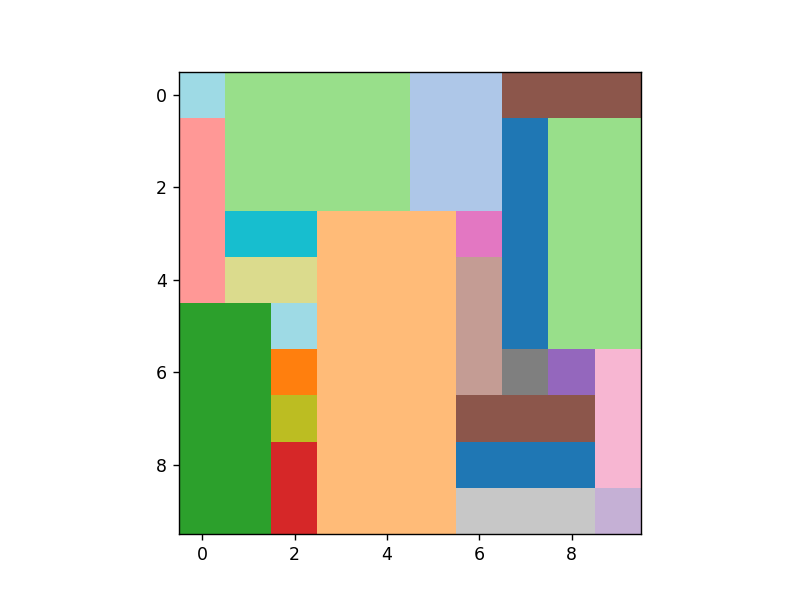

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


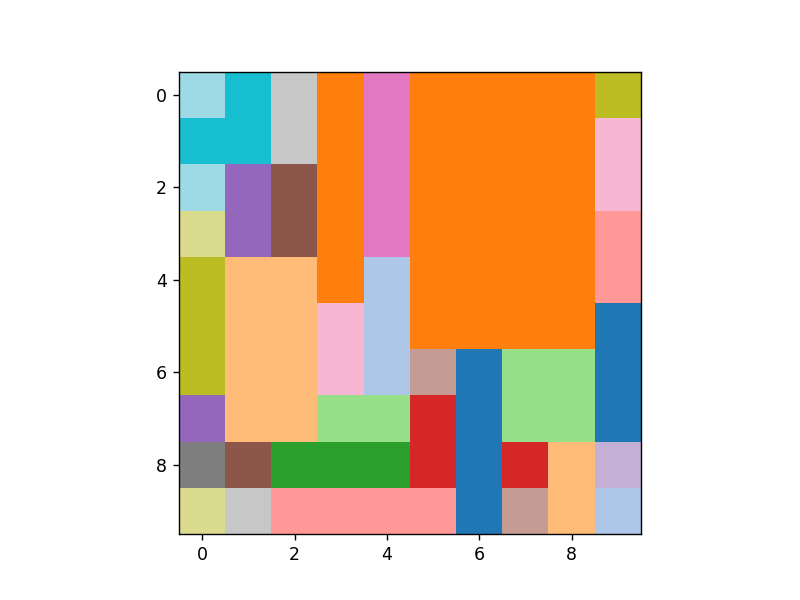

There are 37 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


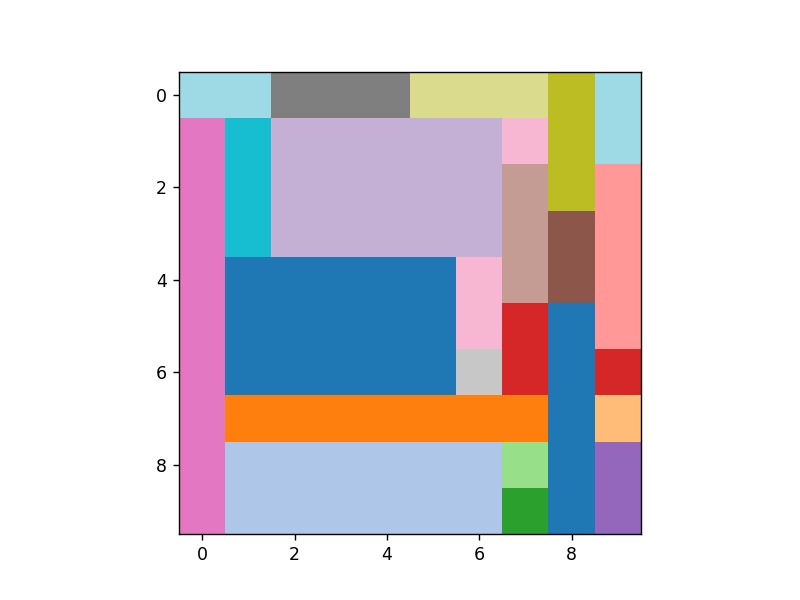

There are 24 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


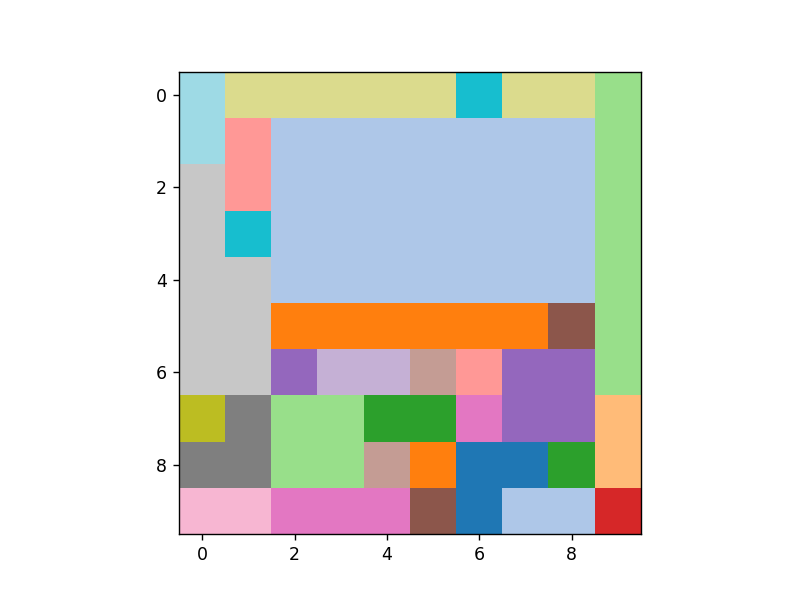

There are 35 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


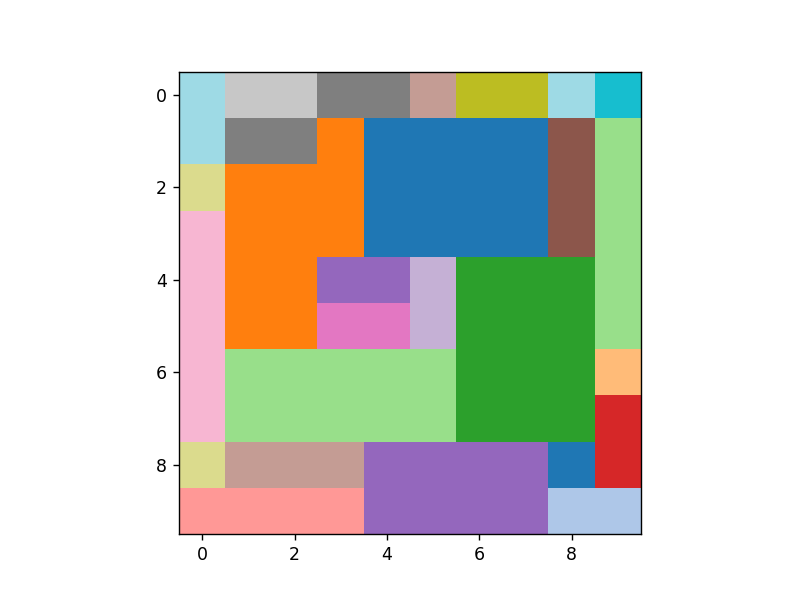

There are 28 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


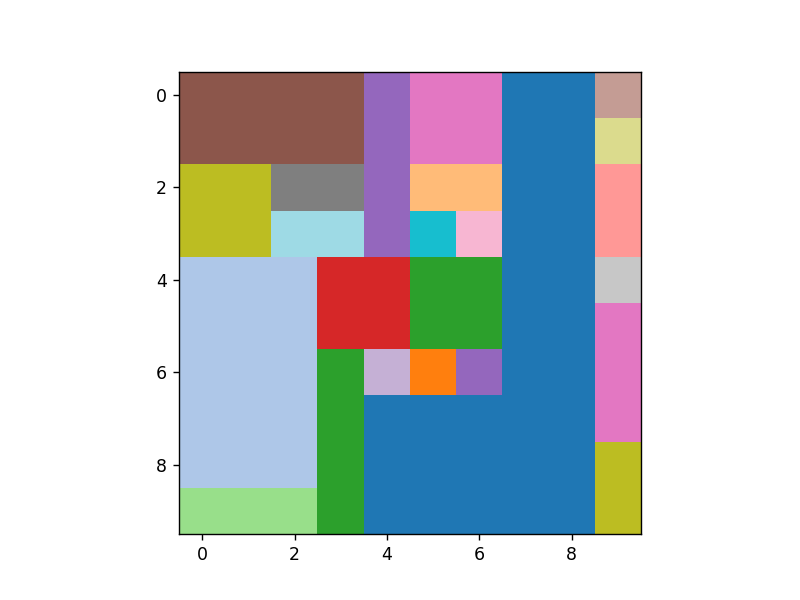

There are 26 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


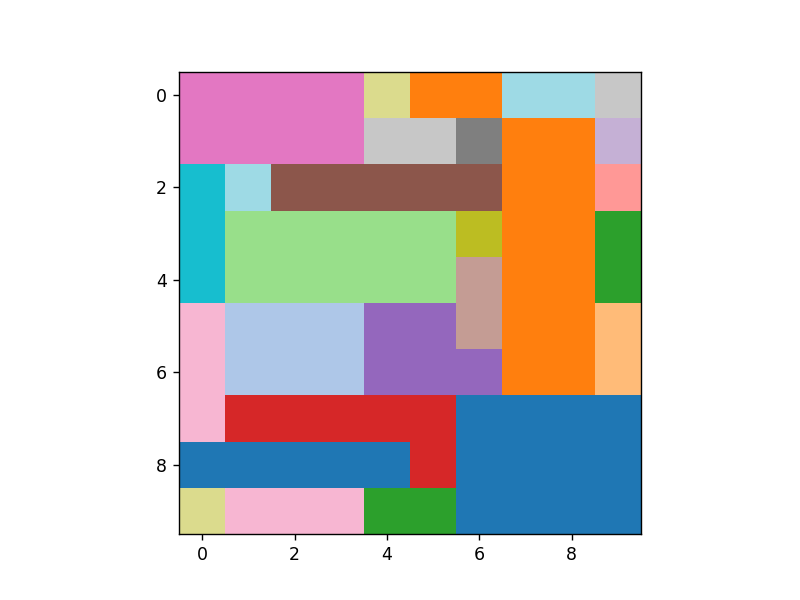

There are 30 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


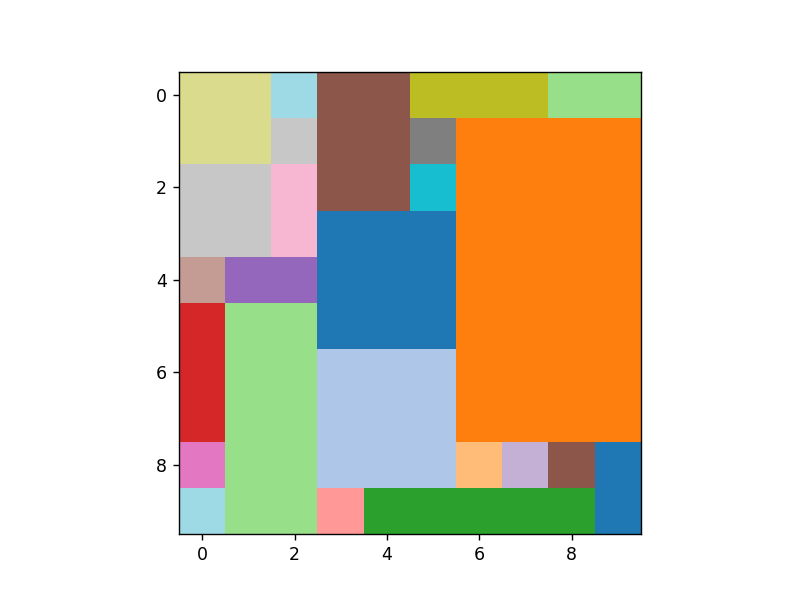

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


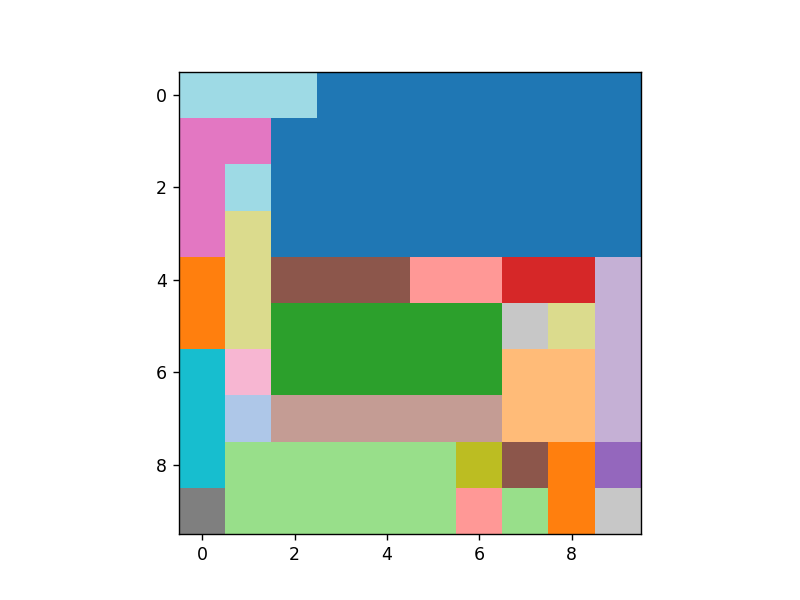

There are 29 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


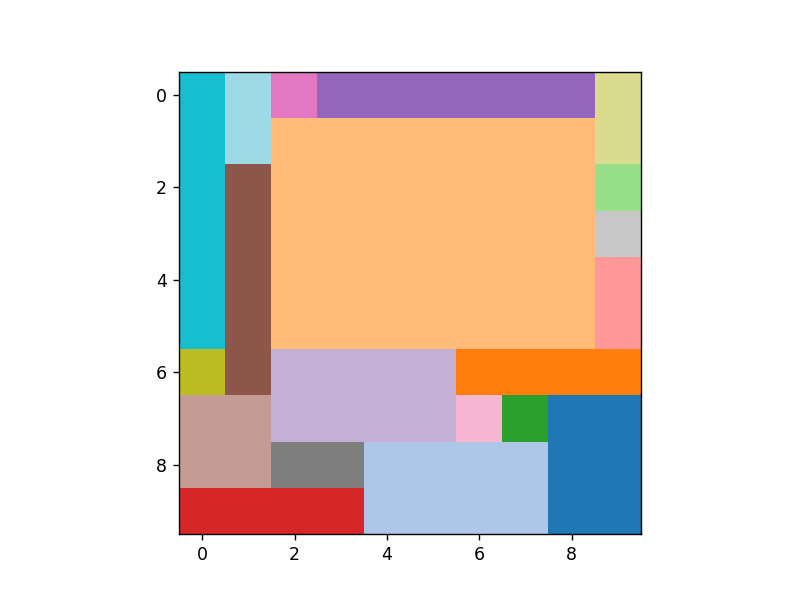

There are 21 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


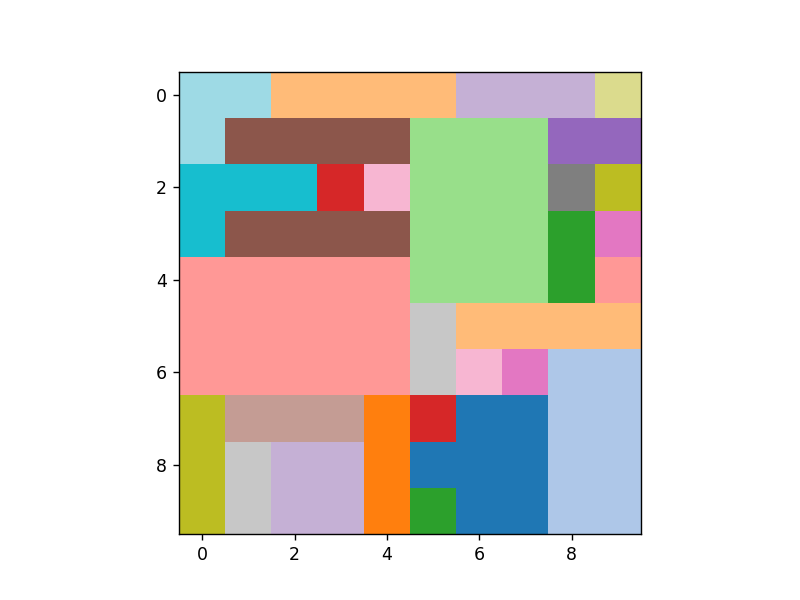

There are 34 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


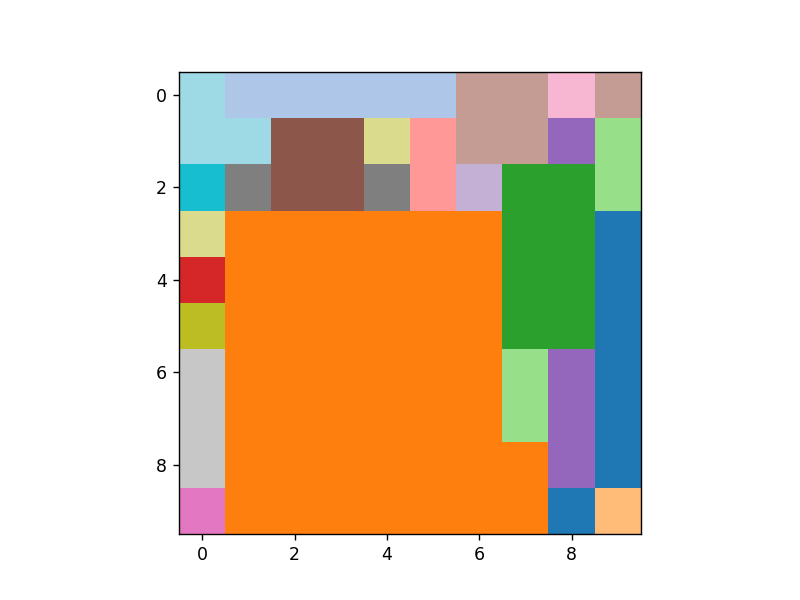

There are 28 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


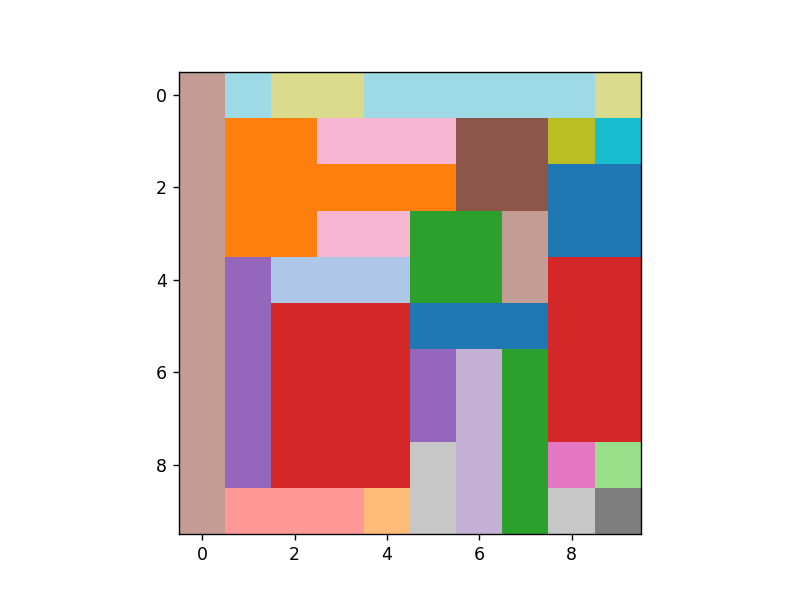

There are 30 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


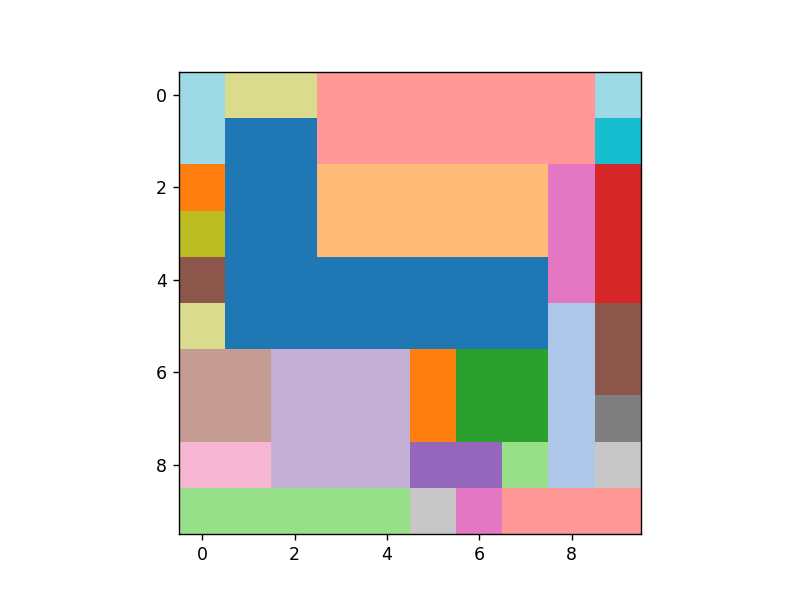

There are 29 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


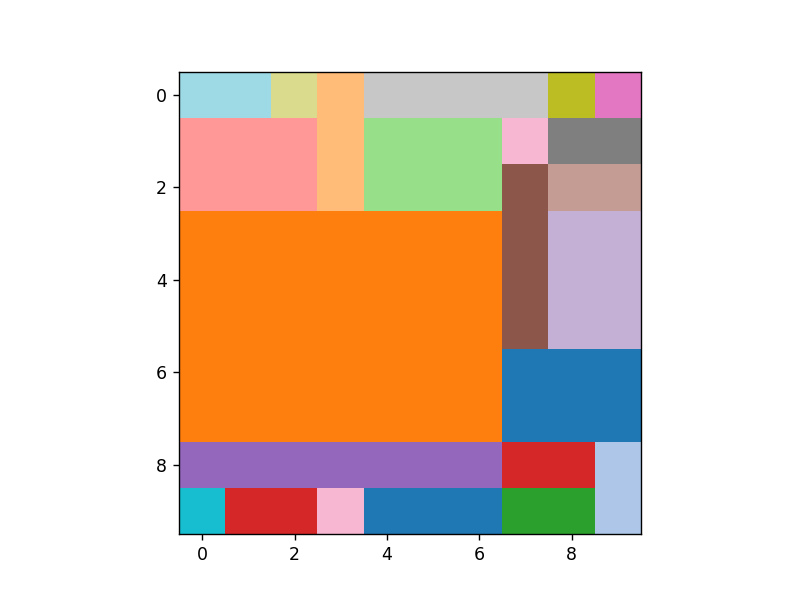

There are 24 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


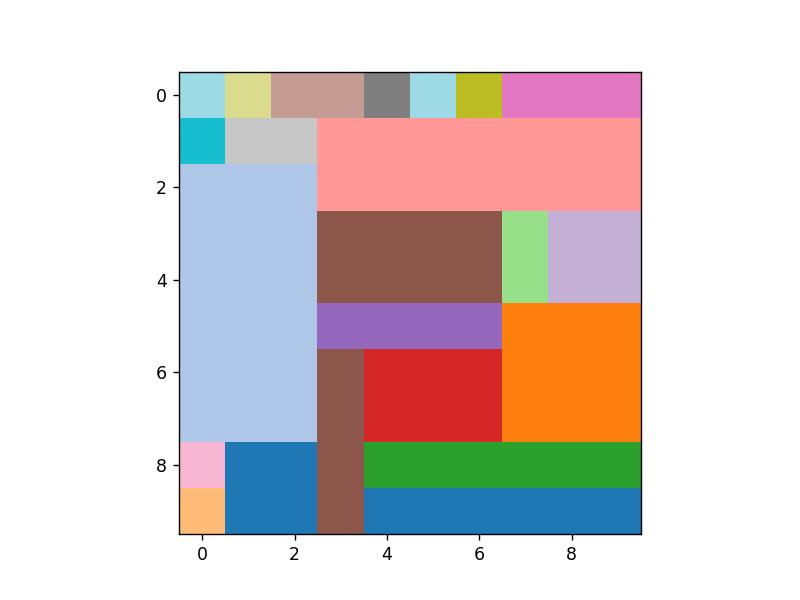

There are 23 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


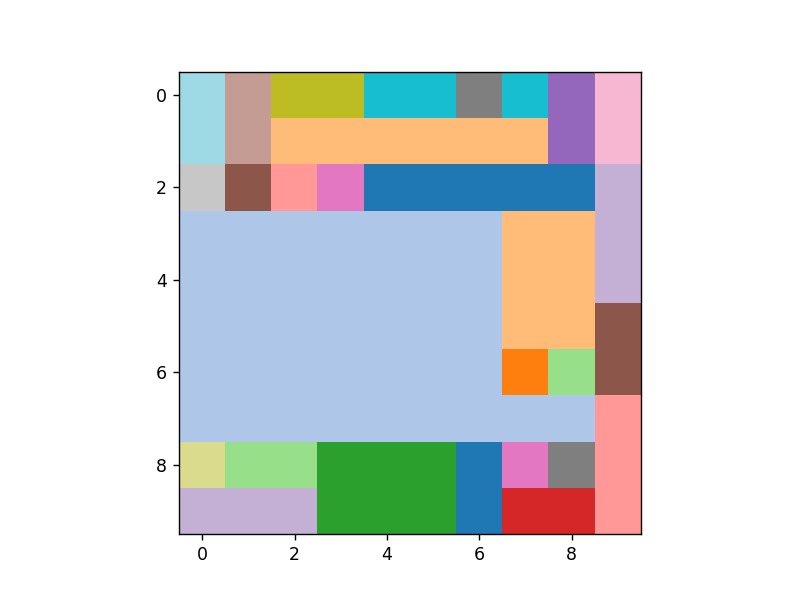

There are 32 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


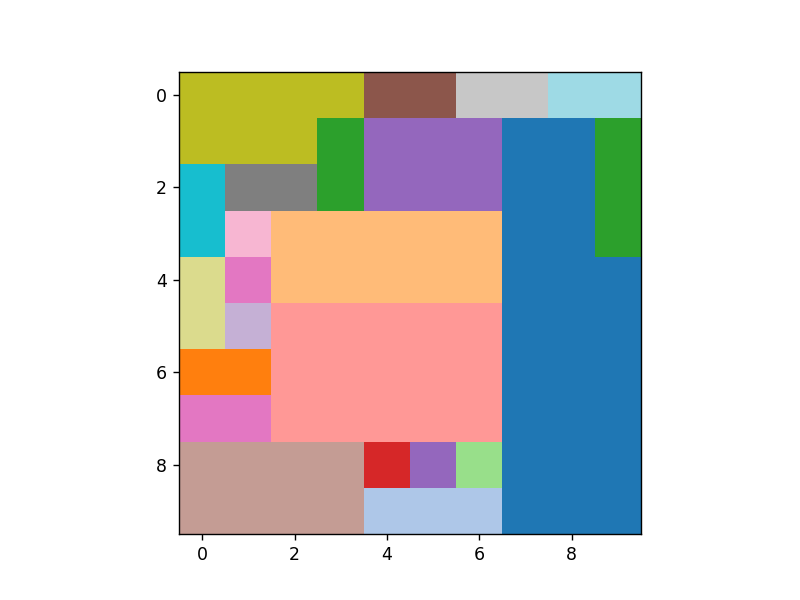

There are 26 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


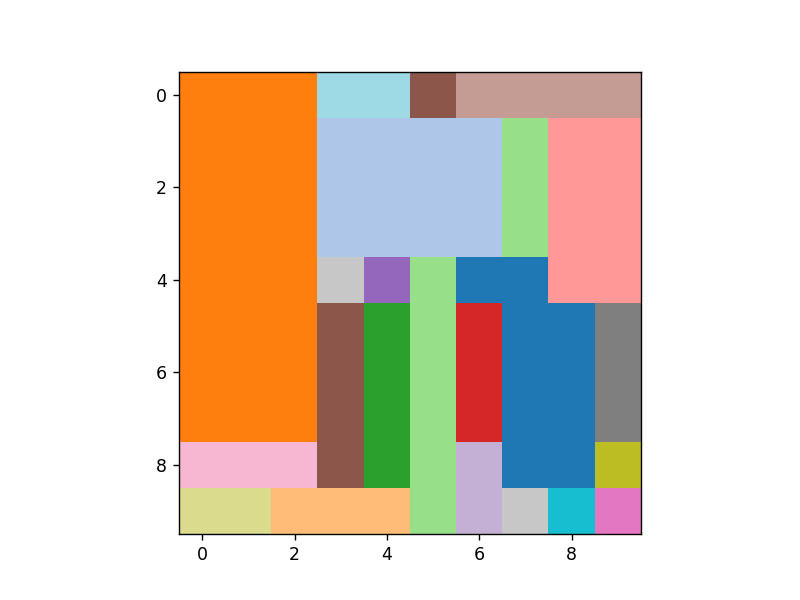

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


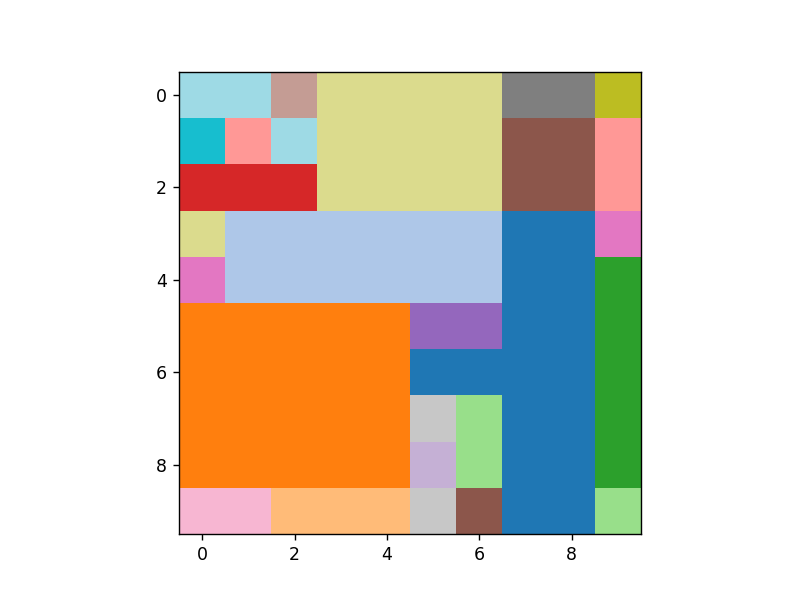

There are 29 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


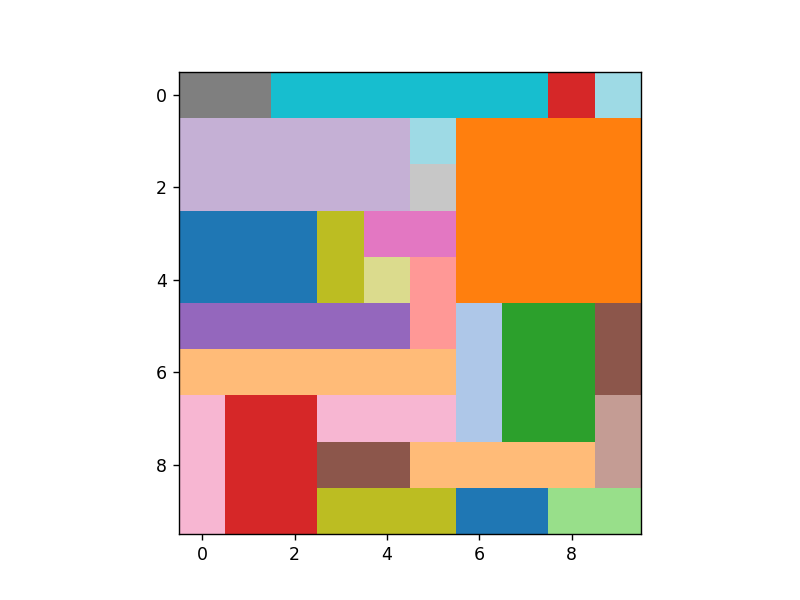

There are 27 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


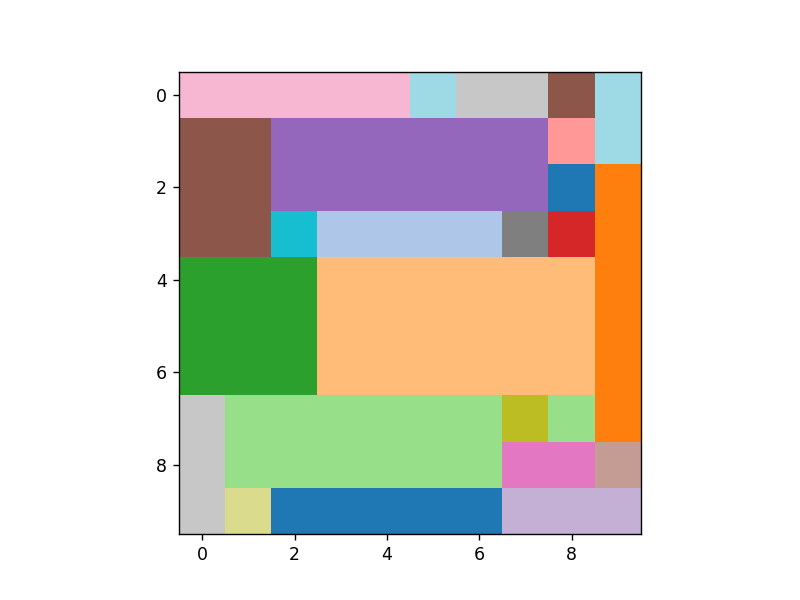

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


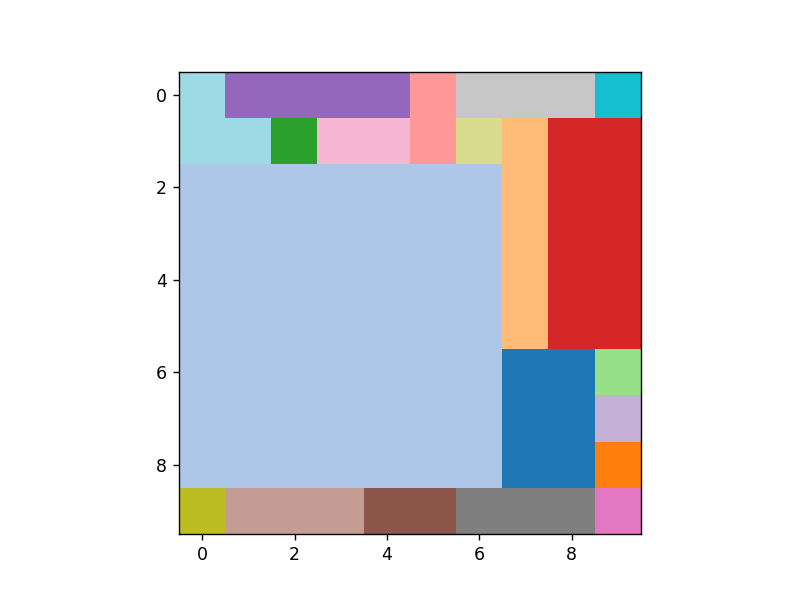

There are 21 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


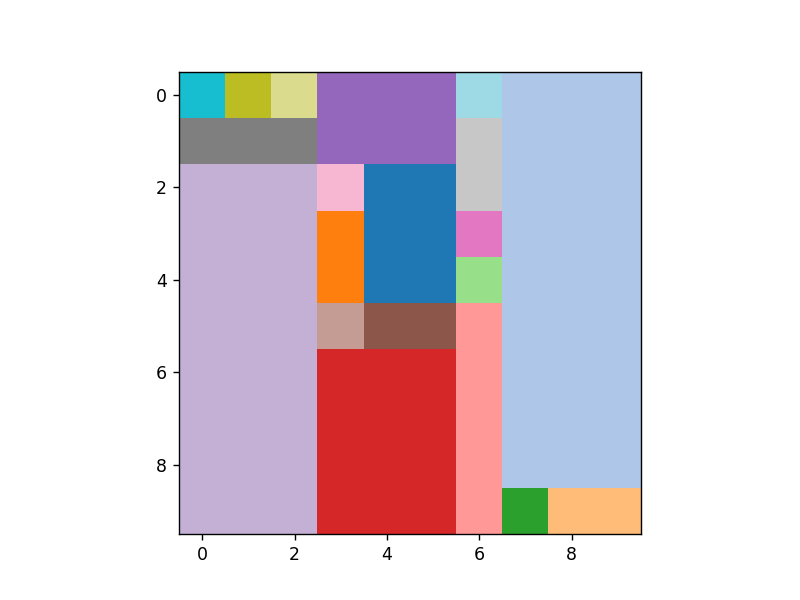

There are 20 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


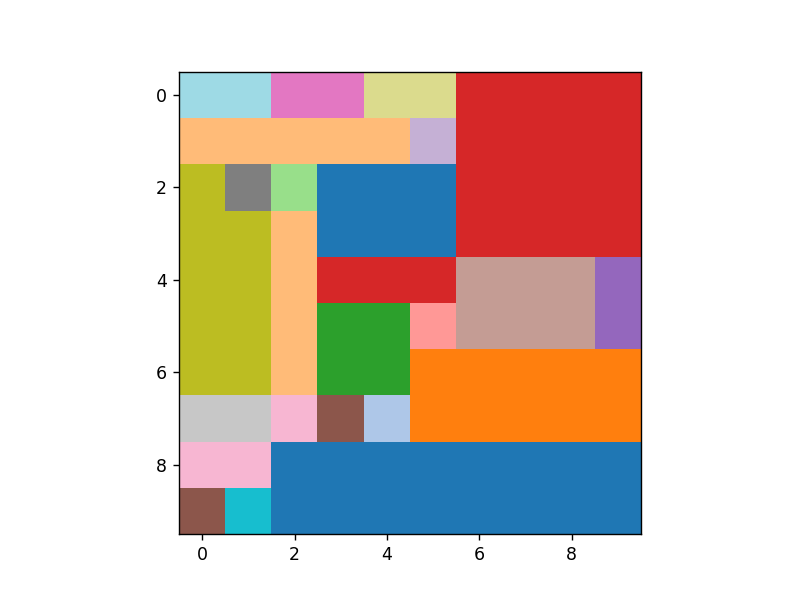

There are 27 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


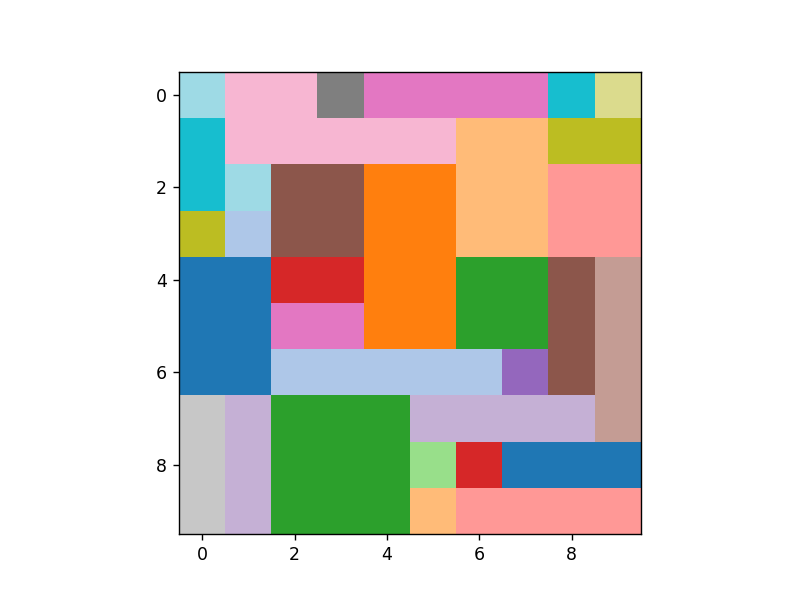

There are 34 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


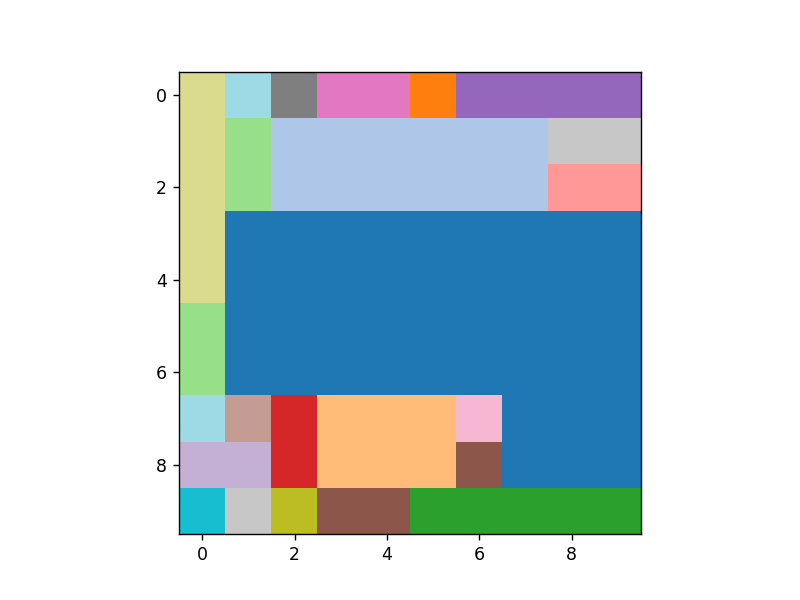

There are 25 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


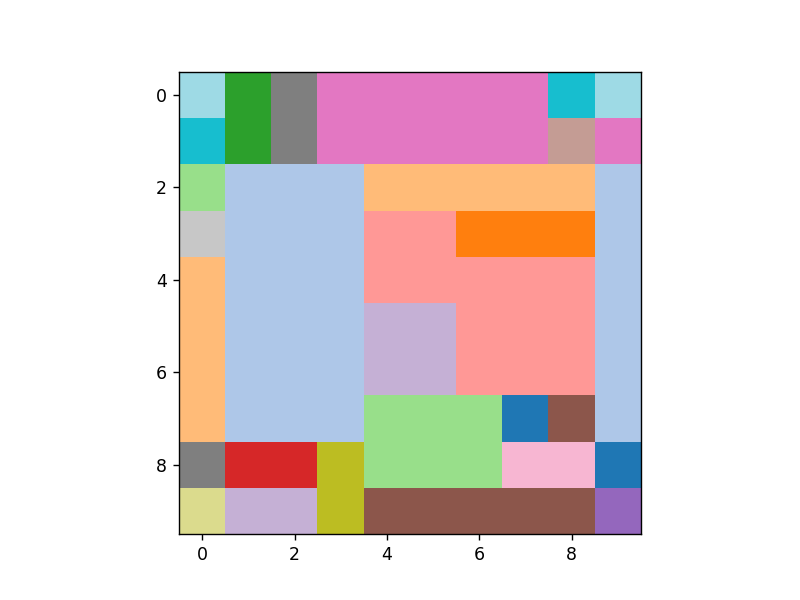

There are 32 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


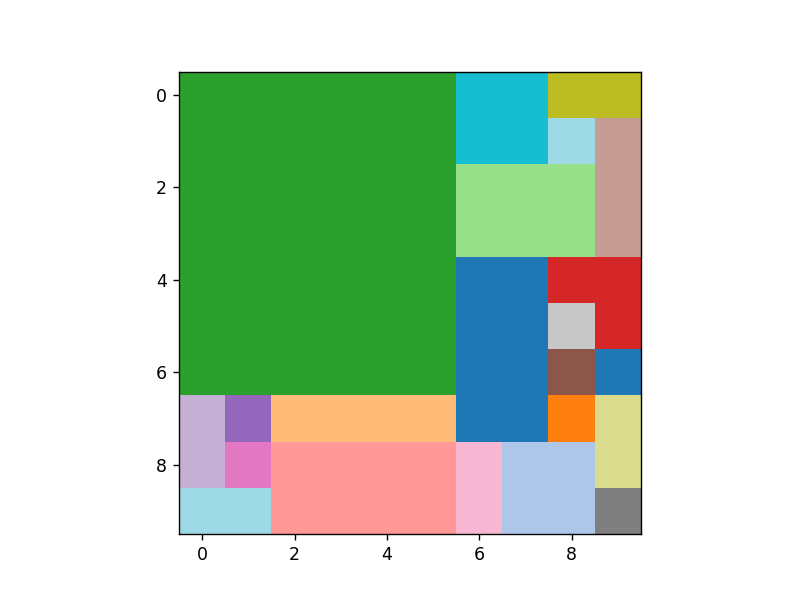

There are 24 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


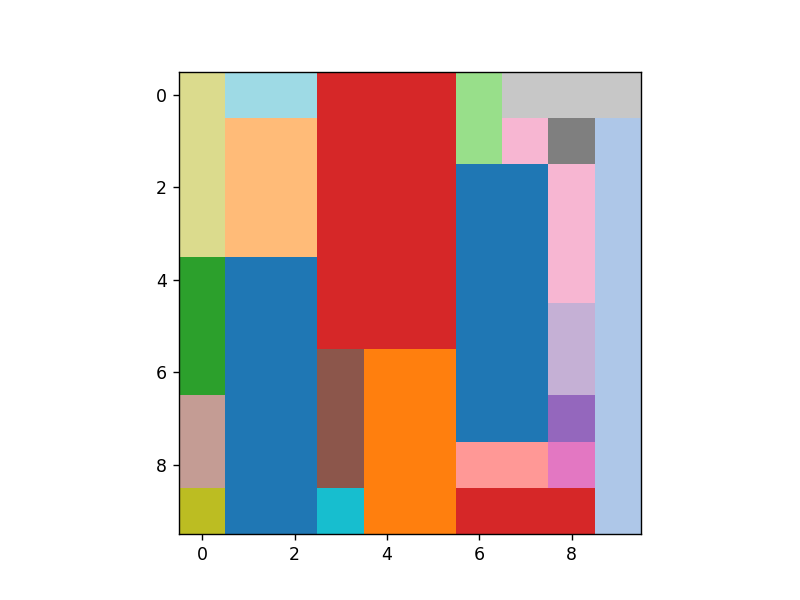

There are 24 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


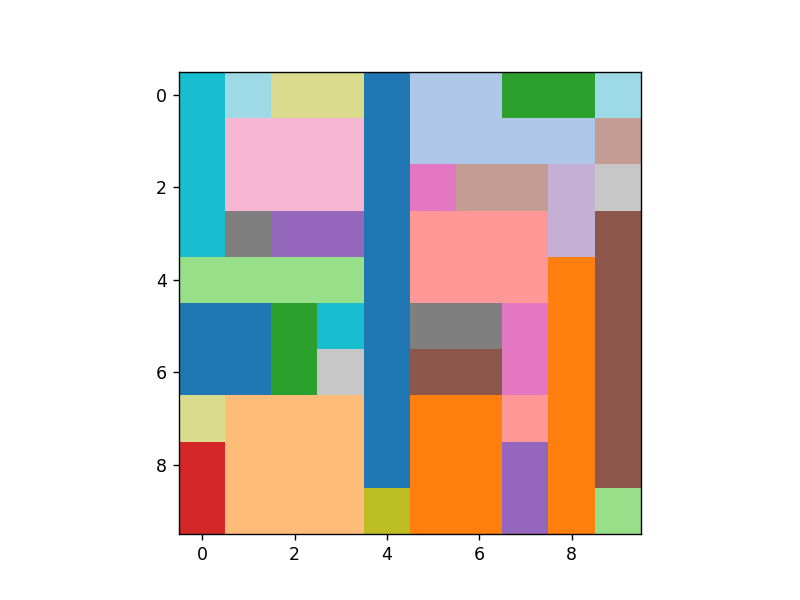

There are 35 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


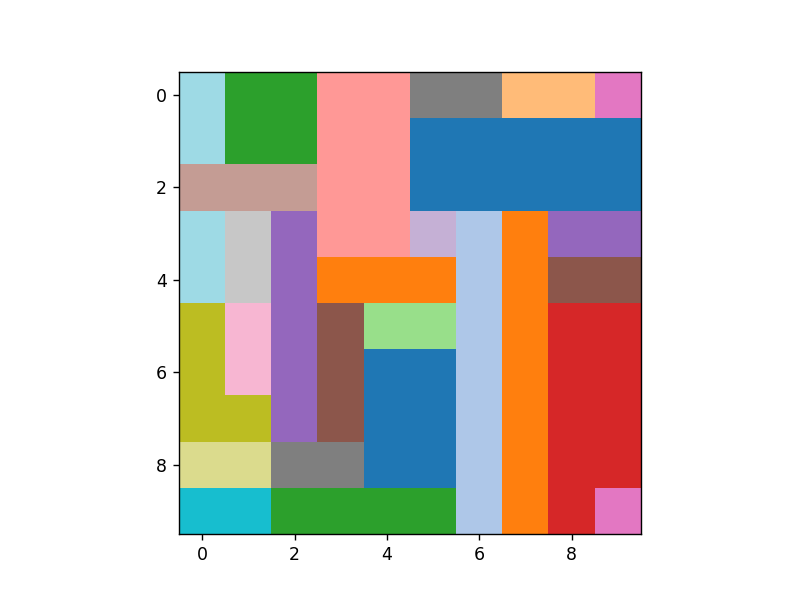

There are 31 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


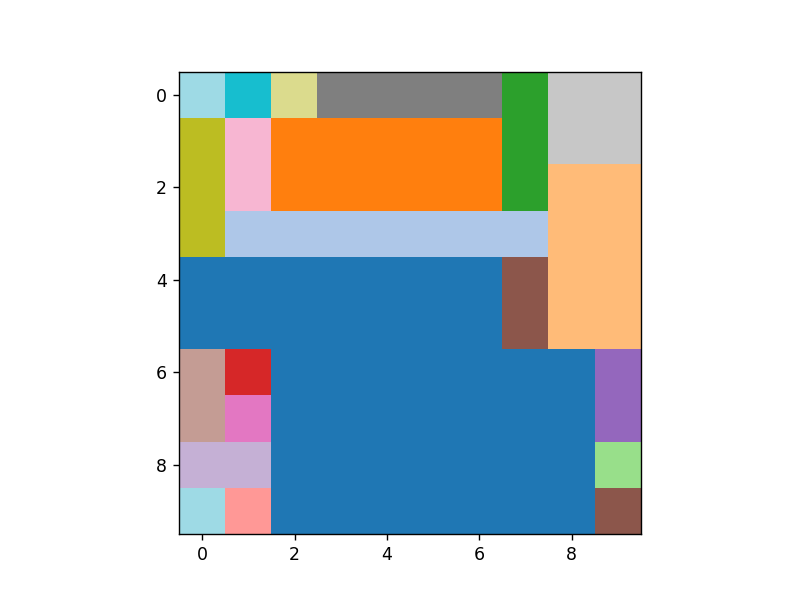

There are 23 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


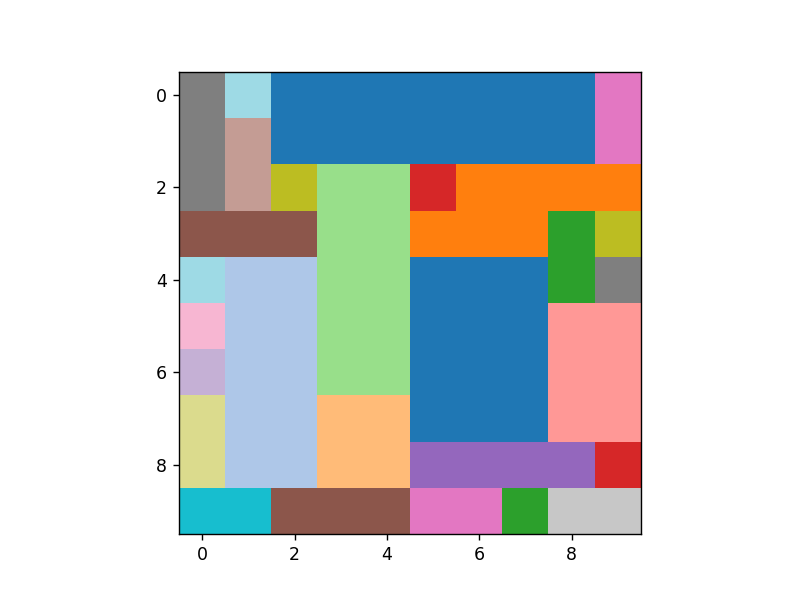

There are 31 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


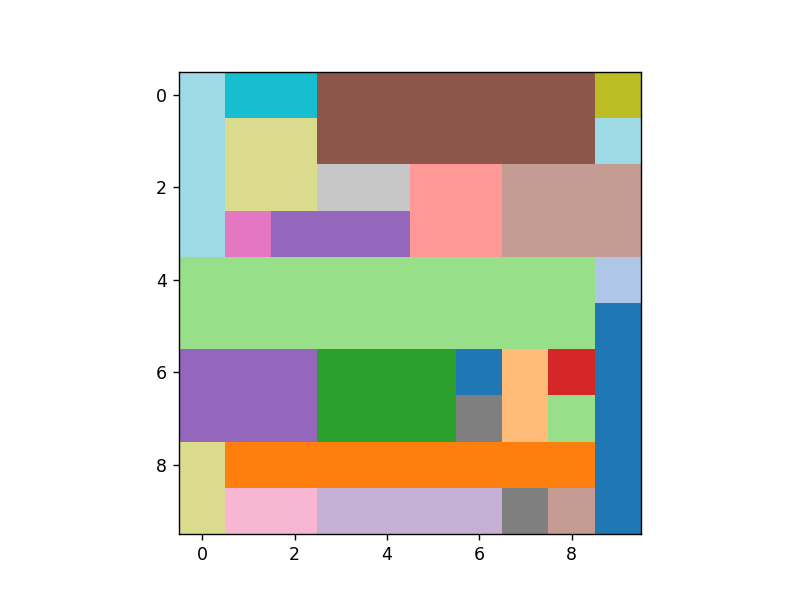

There are 28 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


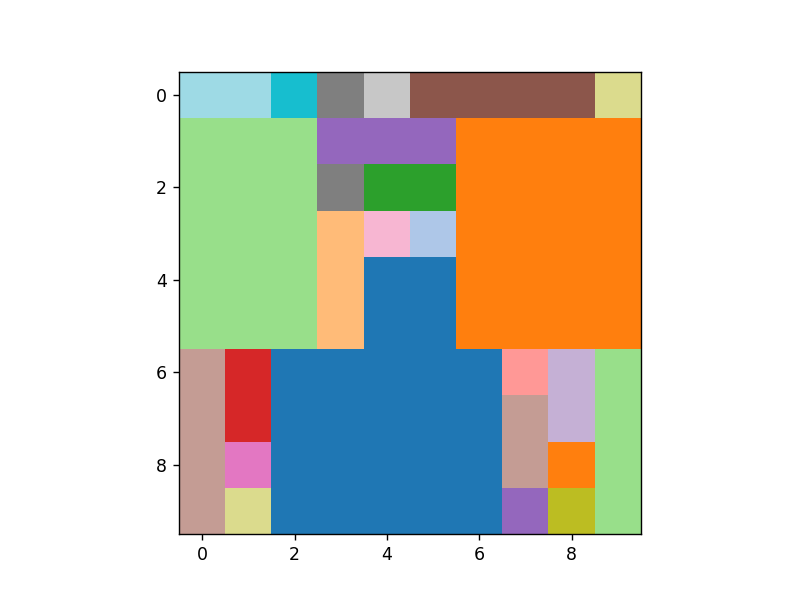

There are 28 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


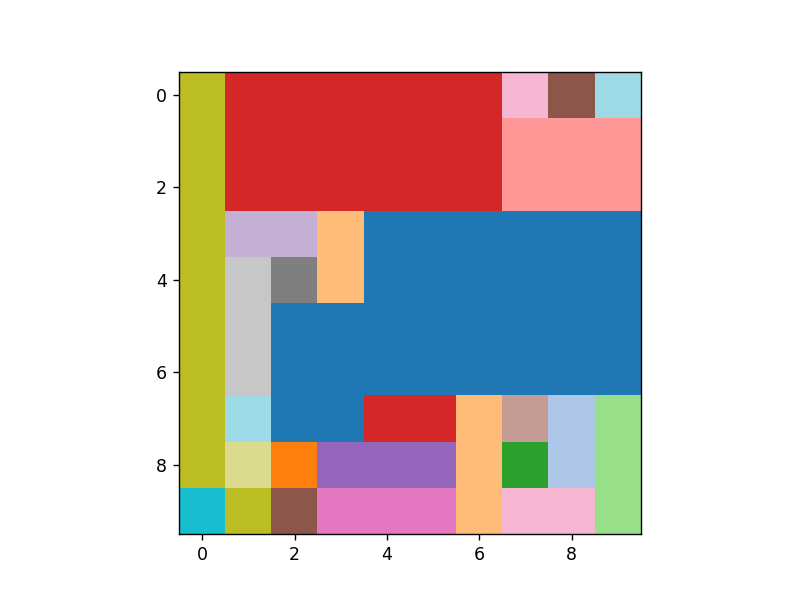

There are 27 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


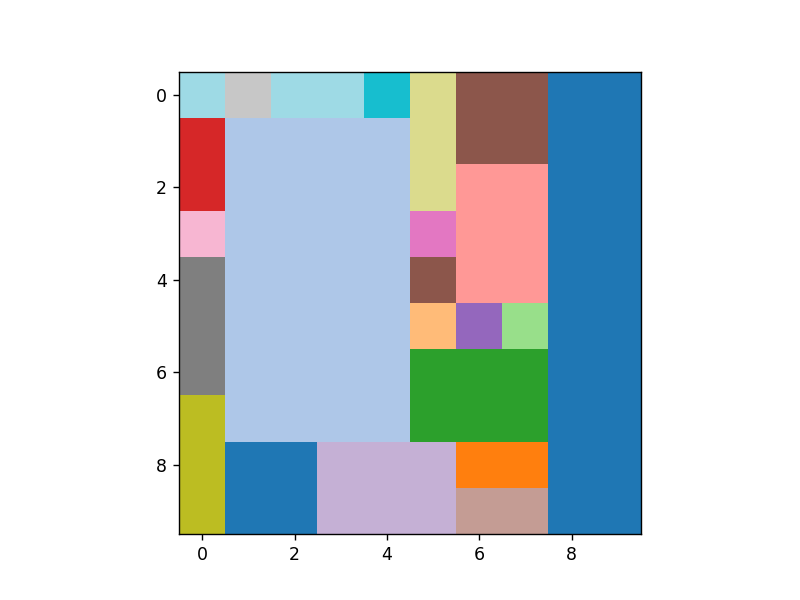

There are 23 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


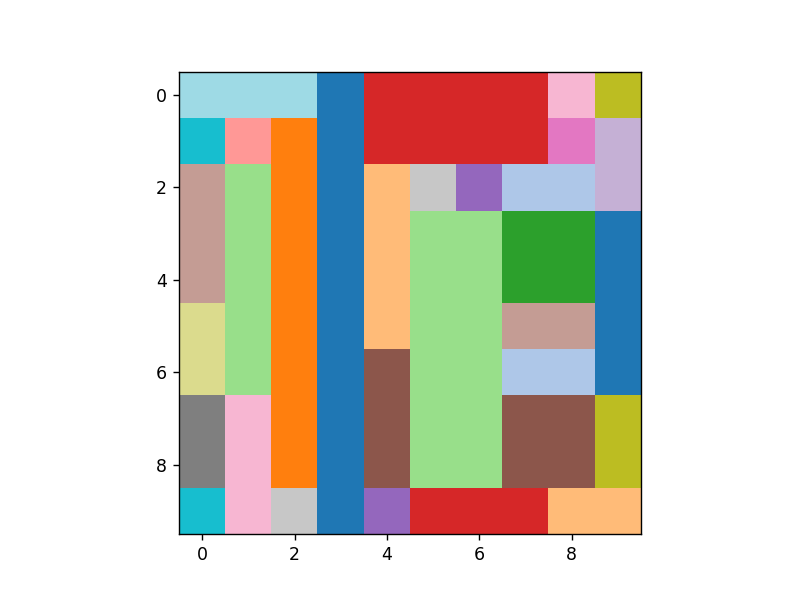

There are 33 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


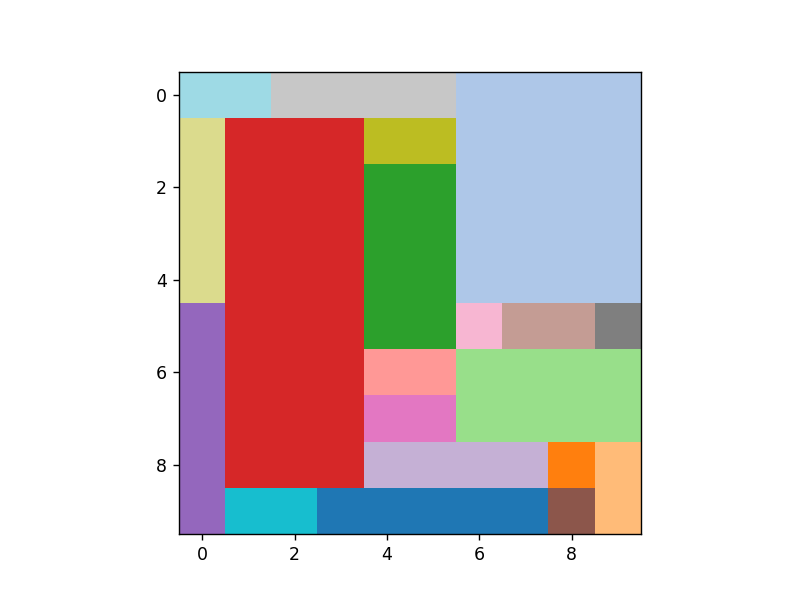

There are 20 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


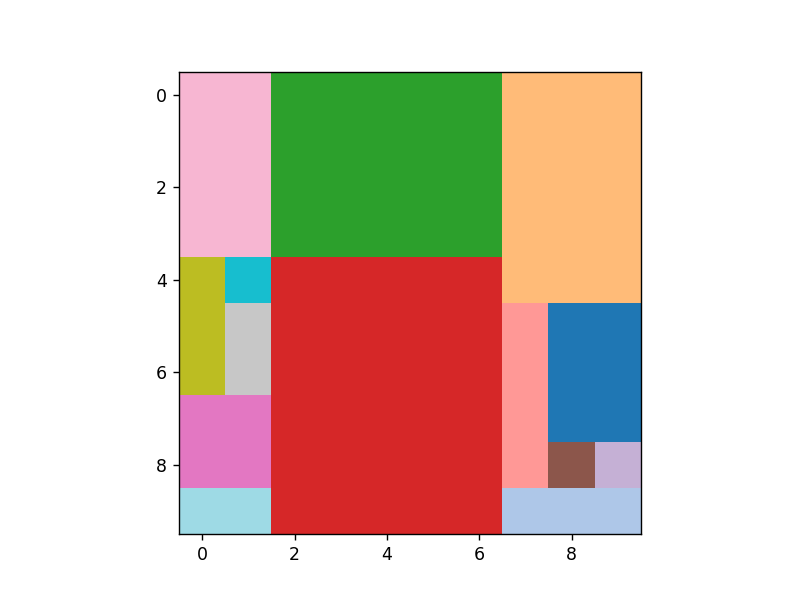

There are 14 communication towers covering 100.0% of the area.


<IPython.core.display.Javascript object>


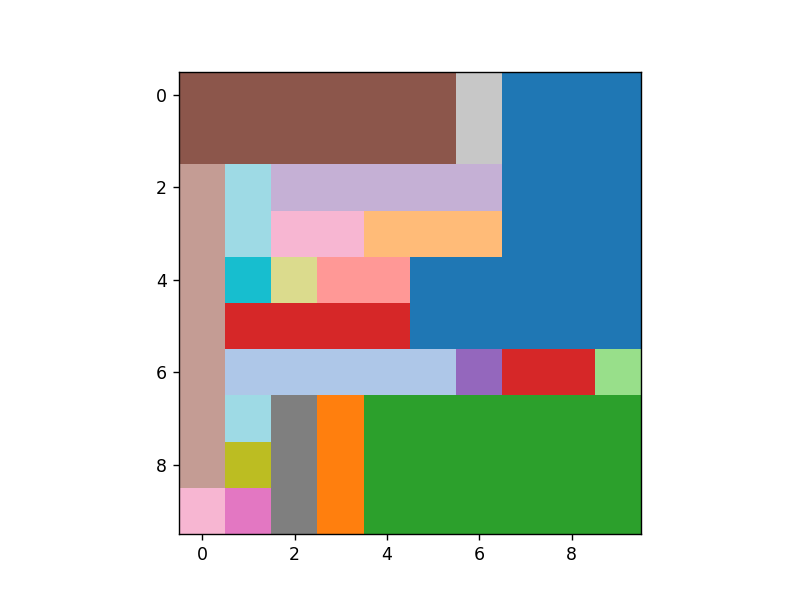

There are 24 communication towers covering 100.0% of the area.
[25, 32, 24, 25, 23, 32, 24, 41, 25, 37, 24, 35, 28, 26, 30, 25, 29, 21, 34, 28, 30, 29, 24, 23, 32, 26, 25, 29, 27, 25, 21, 20, 27, 34, 25, 32, 24, 24, 35, 31, 23, 31, 28, 28, 27, 23, 33, 20, 14, 24]
27


In [53]:
num_of_comm = []
for i in range(50):
    num_of_comm.append(main())

print 'It takes an average of {} communication towers to cover the whole area'.format(sum(num_of_comm)/50)
    

<IPython.core.display.Javascript object>


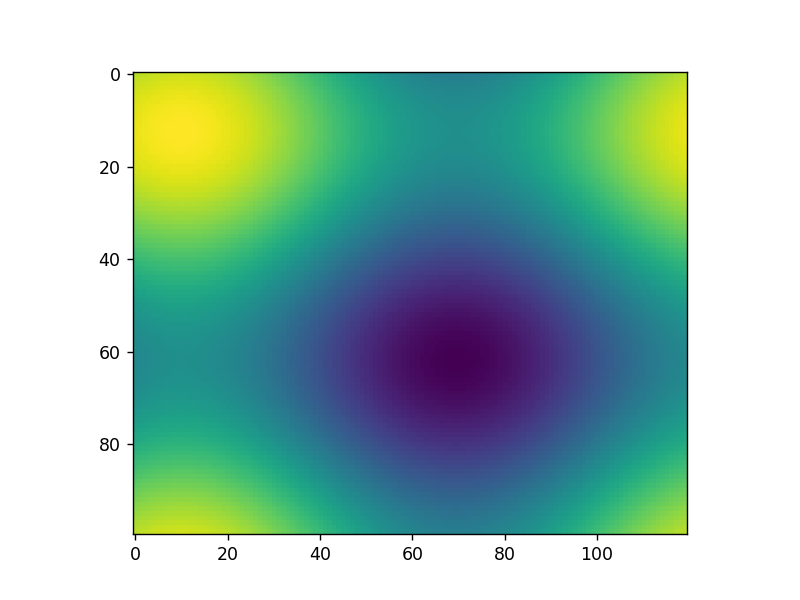

[[ 1.19560003  1.24693237  1.29754214 ...,  1.09134159  1.14368821
   1.19560003]
 [ 1.18368981  1.23502214  1.28563192 ...,  1.07943136  1.13177799
   1.18368981]
 [ 1.16785047  1.21918281  1.26979258 ...,  1.06359203  1.11593865
   1.16785047]
 ..., 
 [ 1.20745732  1.25878965  1.30939943 ...,  1.10319887  1.15554549
   1.20745732]
 [ 1.20353318  1.25486552  1.30547529 ...,  1.09927474  1.15162136
   1.20353318]
 [ 1.19560003  1.24693237  1.29754214 ...,  1.09134159  1.14368821
   1.19560003]]
[[ 1.35779316  1.40543901  1.45181842 ...,  1.25923646  1.30901366
   1.35779316]
 [ 1.33627931  1.38392516  1.43030457 ...,  1.23772261  1.2874998
   1.33627931]
 [ 1.31102251  1.35866837  1.40504778 ...,  1.21246582  1.26224301
   1.31102251]
 ..., 
 [ 1.38926095  1.43690681  1.48328622 ...,  1.29070426  1.34048145
   1.38926095]
 [ 1.37547744  1.4231233   1.46950271 ...,  1.27692075  1.32669794
   1.37547744]
 [ 1.35779316  1.40543901  1.45181842 ...,  1.25923646  1.30901366
   1.35779316]]
[

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    print f(x,y)
    im = plt.imshow(f(x, y), animated=True)
    ims.append([im])
    

print len(ims)
print len(ims[0])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()